Implementation of a Multi Layered Perceptron for classification of MNIST data from scratch

Required Imports

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import math
import copy
from sklearn.metrics import confusion_matrix
from numpy.lib.arraysetops import unique
import seaborn as sns
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

The class Responsible for handling whole of the network.

In [ ]:
class NeuralNetwork:

  def visualize(self):

    # obtain one batch of training images
    dataiter = iter(self.train_loader)
    images, labels = next(dataiter)
    images = images.numpy()

    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(images[idx]), cmap='gray')

        # print out the correct label for each image
        ax.set_title(str(labels[idx].item()))
    plt.show()

  #differetnt initializaion methods
  def int_param_Glorot(self, params):

    for index in range(len(self.layer_dimensions) - 1):

      currNum = self.layer_dimensions[index]
      nextNum = self.layer_dimensions[index + 1]

      lower_bound = -1 * math.sqrt(6/(currNum + nextNum))
      upper_bound = -1 * lower_bound

      params["w"][index] = torch.tensor(np.random.uniform(lower_bound, upper_bound, size=nextNum * currNum).reshape(nextNum, currNum)).to(self.device)
      params["b"][index] = torch.tensor(np.zeros(nextNum)).to(self.device)

    return params

  def init_param_he(self, params):

    for index in range(len(self.layer_dimensions) - 1):

      currNum = self.layer_dimensions[index]
      nextNum = self.layer_dimensions[index + 1]

      params["w"][index] = torch.randn(currNum * nextNum).reshape(nextNum, currNum).to(self.device) * math.sqrt(2.0/currNum)
      params["b"][index] = torch.randn(nextNum).to(self.device)

    return params

  def create_layers(self):

    layers = {
       "z" : [torch.zeros((self.layer_dimensions[index])).to(torch.float).to(self.device) for index in range(len(self.layer_dimensions))],
       "a" : [torch.zeros((self.layer_dimensions[index])).to(torch.float).to(self.device) for index in range(len(self.layer_dimensions))]
    }

    return layers

  def init_params(self, initializer = "None"):
    params = {"w" : [torch.zeros((self.layer_dimensions[index + 1], self.layer_dimensions[index])).to(torch.float).to(self.device) for index in range(len(self.layer_dimensions) - 1)],
        "b": [torch.zeros((self.layer_dimensions[index + 1])).to(torch.float).to(self.device) for index in range((len(self.layer_dimensions) - 1))]
      }




    if initializer in self.init_methods.keys():
      params = self.init_methods[self.init_method](params)


    return params



  def softmax(self, layer):
    return torch.exp(layer)/sum(torch.exp(layer))

  def sigmoid_diff(self, layer):
    return (self.sigmoid(layer) * ( 1 - self.sigmoid(layer)))

  def relu_diff(self, layer):

    return torch.where(layer > 0, torch.tensor(1.0), torch.tensor(0.0))

  def sigmoid(self, layer):
    return (1/( 1 + torch.exp(-layer)))

  def relu(self, layer):
    relu_output = torch.relu(layer)
    return relu_output


  def tanh(self, layer):
    return torch.tanh(layer)

  def tanh_diff(self, layer):
    return 1 - (self.tanh(layer))**2

  def cross_entorpy(self, predict, label):
    return -math.log(predict[label.item()])

  def forward_propagation(self, image, label):

    loss= 0
    for index in range(len(self.layer_dimensions)):

        if(index == 0):
          self.layers["a"][index] = image.view(-1).to(torch.float64)

        elif(index == len(self.layer_dimensions) - 1):
          self.layers["z"][index] = torch.mv(self.params["w"][index - 1].to(torch.float), self.layers["a"][index - 1].to(torch.float)) + self.params["b"][index - 1].to(torch.float)
          self.layers["a"][index] = self.softmax(self.layers["z"][index])

        else:
          self.layers["z"][index] = torch.mv(self.params["w"][index - 1].to(torch.float), self.layers["a"][index - 1].to(torch.float)) + self.params["b"][index - 1].to(torch.float)
          self.layers["a"][index] = self.all_activations[self.activation](self.layers["z"][index])

    loss += self.cross_entorpy(self.layers["a"][len(self.layer_dimensions) - 1], label)


    return (loss, torch.argmax(self.layers["a"][len(self.layer_dimensions) - 1]))

  def onehot(self, label):
    result = torch.zeros(self.layer_dimensions[-1])
    result[label] = 1
    return  result

  def sgd(self, label, params = None):

    dparam = self.init_params()
    dlayers = self.create_layers()

    if params is None:
      params = self.params

    for index in range(len(self.layer_dimensions)-1, -1, -1):

      if(index == len(self.layer_dimensions) - 1):
        dlayers["z"][index] = self.layers["a"][index] - self.onehot(label)
      elif(index == 0):
        dparam["w"][index] = torch.mm(dlayers["z"][index + 1].to(torch.float).reshape(self.layer_dimensions[index + 1],1), self.layers["a"][index].to(torch.float).reshape(1, self.layer_dimensions[index]))
        dparam["b"][index] = dlayers["z"][index+1]
      else:
        dparam["w"][index] = torch.mm(dlayers["z"][index + 1].to(torch.float).reshape(self.layer_dimensions[index + 1],1), self.layers["a"][index].to(torch.float).reshape(1, self.layer_dimensions[index]))
        dparam["b"][index] = dlayers["z"][index+1]
        dlayers["a"][index] = torch.mv(params["w"][index].to(torch.float).transpose(0,1), dlayers["z"][index + 1].to(torch.float))
        dlayers["z"][index] = self.activation_diff[self.activation](self.layers["z"][index])*dlayers["a"][index]

    for index in range(len(self.layer_dimensions) - 1):
      self.paramGrad["w"][index] += dparam["w"][index]
      self.paramGrad["b"][index] += dparam["b"][index]



  def sgd_step(self):

    for index in range(len(self.layer_dimensions) - 1):
      self.params["w"][index] -= self.eta * self.paramGrad["w"][index]
      self.params["b"][index] -= self.eta * self.paramGrad["b"][index]

    self.paramGrad = self.init_params()


  def adam(self, label):

    self.sgd(label = label, params = self.params)



  def adam_step(self):

    m_new = self.init_params()
    v_new = self.beta2 * self.v_old

    for index in range(len(self.layer_dimensions) - 1):
      v_new +=   (1 - self.beta2) * torch.sum((self.paramGrad["w"][index] * self.paramGrad["w"][index]))

    self.v_old = v_new

    for index in range(len(self.layer_dimensions) - 1):
      m_new["w"][index] = self.beta1 * self.m_old["w"][index] + (1 - self.beta1) * self.paramGrad["w"][index]
      m_new["b"][index] = self.beta1 * self.m_old["b"][index] + (1 - self.beta1) * self.paramGrad["b"][index]



      self.params["w"][index] -= (self.eta / math.sqrt(v_new + self.epsilon)) * m_new["w"][index]
      self.params["b"][index] -= (self.eta / math.sqrt(v_new + self.epsilon)) * m_new["b"][index]

      self.m_old["w"][index] = m_new["w"][index]
      self.m_old["b"][index] = m_new["b"][index]



    self.paramGrad = self.init_params()

  def train(self):

    trainLosses = []
    validationLosses = []
    validationAcc = []

    # best_param_copy = copy.deepcopy(self.params)
    # min_validation_loss = float('inf')

    for batch, (images, labels) in enumerate(self.train_loader):

      #train-validation split from the batch
      ratio = math.ceil(images.shape[0] * 0.7)
      training_images = images[0:ratio]
      training_labels = labels[0:ratio]
      validation_images = images[ratio:]
      validation_labels = labels[ratio:]
      trainBatchLoss = 0

      #training phase
      for index in range(len(training_images)):
        image = training_images[index]
        label = training_labels[index]

        (loss, ypred) = self.forward_propagation(image, label)
        trainBatchLoss += loss
        self.optimizers[self.optimization](label)

      #updation of parameters
      self.step[self.optimization]()


      #validation phase
      validationLoss = 0
      accuracy = 0
      total = 0
      flag  = True

      #validating with the set
      for index in range(len(validation_images)):
        image = validation_images[index]
        label = validation_labels[index]

        (loss, ypred) = self.forward_propagation(image, label)
        validationLoss += loss

        if(ypred.item() == label.item()):
          accuracy += 1
        total += 1

      accuracy /= total

      #::::tried to preserve only those weights that
      #::::strictly decreases the loss on validation set,
      #::::also hoping a smoother curve
      #::::but approach does not seem to work.
      # if(validationLoss <= min_validation_loss):
      #    min_validation_loss = validationLoss
      #    #print(min_validation_loss, batch)
      #    best_param_copy = copy.deepcopy(self.params)
      #    flag = True
      # else:
      #   self.params = copy.deepcopy(best_param_copy)
      #   flag = False



      if(batch % self.log_interval == 0 and flag):
        validationAcc.append(accuracy)
        validationLosses.append(validationLoss/len(validation_images))
        trainLosses.append(trainBatchLoss/len(training_images))


    return (trainLosses, validationLosses, validationAcc)

  def test(self):
    yTrue = []
    yPred = []
    testLoss = 0

    accuracy = 0
    total = 0
    for batch, (images, labels) in enumerate(self.test_loader):
        collection = zip(images, labels)
        for (image, label) in collection:
          (loss, predLabel) = self.forward_propagation(image, label)
          testLoss += loss
          if(label == predLabel):
            accuracy += 1
          total += 1
          yTrue.append(label)
          yPred.append(predLabel)

    self.plotConfusionMatrix(yTrue, yPred)

    return (testLoss/total, accuracy/total)

  def plotConfusionMatrix(self, yTrue, yPred):
    # Create a heatmap of the confusion matrix
    confusion_mat = confusion_matrix(yTrue, yPred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    #plt.show()


  def __init__(self, batch_size, hidden_layers, learning_rate, init_method, activation, optimization, beta1, beta2, epsilon, log_interval):

    # Check if GPU is available
    if torch.cuda.is_available():
      self.device = torch.device("cuda")  # Use GPU
    else:
      self.device = torch.device("cpu")   # Use CPU

    print(self.device)




    self.init_method = init_method
    self.activation = activation
    self.optimization = optimization
    self.eta = learning_rate
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    self.batch_size = batch_size
    self.log_interval = log_interval

    self.all_activations = {"sigmoid" : self.sigmoid,
                       "relu": self.relu,
                       "tanh": self.tanh}
    self.activation_diff = {
        "sigmoid" : self.sigmoid_diff,
        "relu" : self.relu_diff,
        "tanh": self.tanh_diff
    }

    self.init_methods = {"Glorot" : self.int_param_Glorot, "he" : self.init_param_he}

    self.optimizers = {"sgd" : self.sgd, "adam" : self.adam}
    self.step = {"sgd" : self.sgd_step, "adam" : self.adam_step}


    # number of subprocesses to use for data loading
    num_workers = 0

    # convert data to torch.FloatTensor
    self.transform = transforms.ToTensor()

    # choose the training and test datasets
    self.train_data = datasets.MNIST(root='data', train=True,
                                      download=True, transform=self.transform)
    self.test_data = datasets.MNIST(root='data', train=False,
                                      download=True, transform=self.transform)

    # prepare data loaders

    self.test_loader = torch.utils.data.DataLoader(self.test_data, batch_size=self.batch_size,
        num_workers=num_workers)
    self.train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=self.batch_size,
        num_workers=num_workers)

    self.image_height = self.train_data[0][0].shape[1]
    self.image_width = self.test_data[0][0].shape[2]

    self.layer_dimensions = [self.image_height * self.image_width] + hidden_layers + [unique(self.train_data.targets).shape[0]]
    self.params = self.init_params(initializer = self.init_method)
    self.paramGrad = self.init_params()
    self.layers = self.create_layers()

    self.m_old = self.init_params()
    self.v_old = 0


Function to be called to perform several experiments with varying parameters.

In [ ]:
def experiment(id, batch_size, hidden_layers, learning_rate, init_method, activation, optimization, beta1 = 0.9 , beta2 = 0.5, epsilon = 1e-8, log_interval = 200, epochs = 1):
  #start
  print("starting experiment: ", id)

  #initializing the model
  nn = NeuralNetwork(batch_size, hidden_layers,learning_rate, init_method, activation, optimization, beta1, beta2, epsilon, log_interval)
  #visualizing first few data
  nn.visualize()

  #containers to hold performance statistics for plotting
  trainLossesList = []
  validationLossesList = []
  validationAccList = []

  #iteration over epochs
  for epoch in range(epochs):
    (trainLosses, validationLosses, validationAccuracy) = nn.train()
    trainLossesList += trainLosses
    validationLossesList += validationLosses
    validationAccList += validationAccuracy

  plt.title("train & validation losses, validation accuracies for every 200 batches of every epoch:")
  plt.plot(np.linspace(0, len(trainLossesList)-1, len(trainLossesList)) ,trainLossesList, label = "train losses")
  plt.plot(np.linspace(0, len(validationLossesList)-1, len(trainLossesList)), validationLossesList, label = "validation losses")
  plt.plot(np.linspace(0, len(validationAccList) - 1, len(validationAccList)), validationAccList, label = "validation accuracies")
  plt.legend()
  plt.show()

  #model is ready to test
  (testloss, accuracy) = nn.test()

  print("test accuracy: ", accuracy)
  print("total test loss:", testloss)
  print("experiment ", id, "completed")
  print("*" * 150)


Experimentation on different architecture, Initialization, Activation functions, & optimizers

*   The BASELINE model achieves appx. 96% accuracy over test set when trained for 15 epochs.

starting experiment:  1
cpu


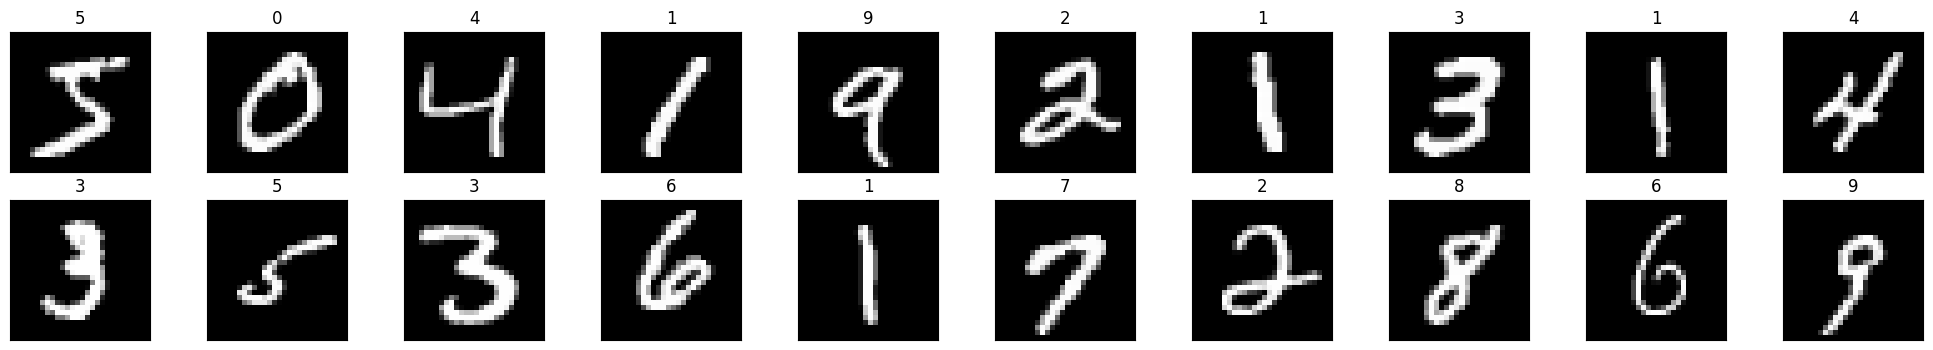

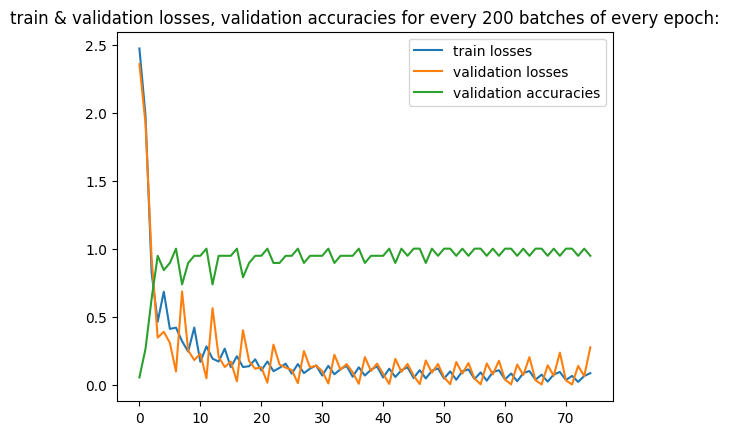

test accuracy:  0.966
total test loss: 0.11274364380289446
experiment  1 completed
******************************************************************************************************************************************************


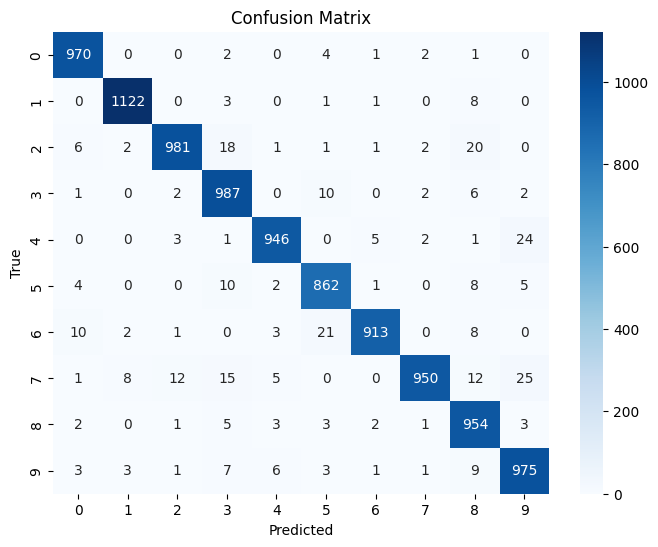

In [ ]:
#the baseline model
experiment(id = 1, batch_size = 64, hidden_layers = [500,250,100], learning_rate =  0.01, init_method = "Glorot", activation = "sigmoid", optimization = "sgd", log_interval = 200, epochs = 15)



*   With ReLU activation function accuracy achieved is around 98%:



starting experiment:  2
cpu


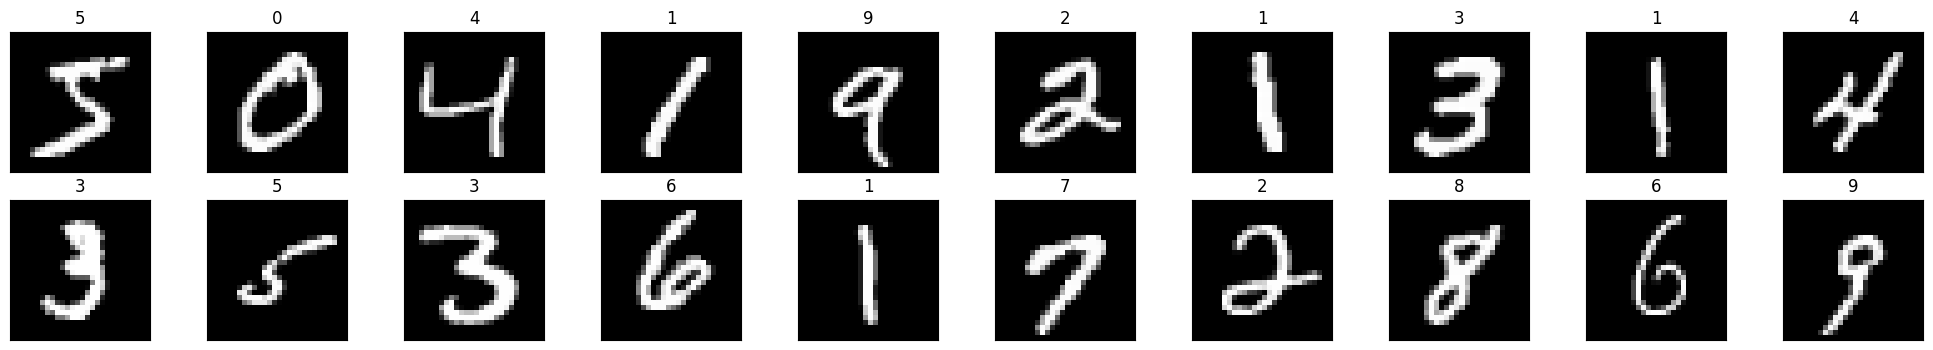

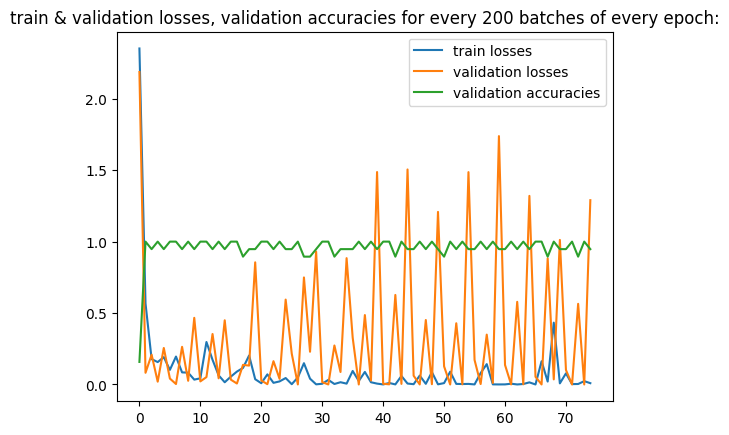

test accuracy:  0.9799
total test loss: 0.09861914783341084
experiment  2 completed
******************************************************************************************************************************************************


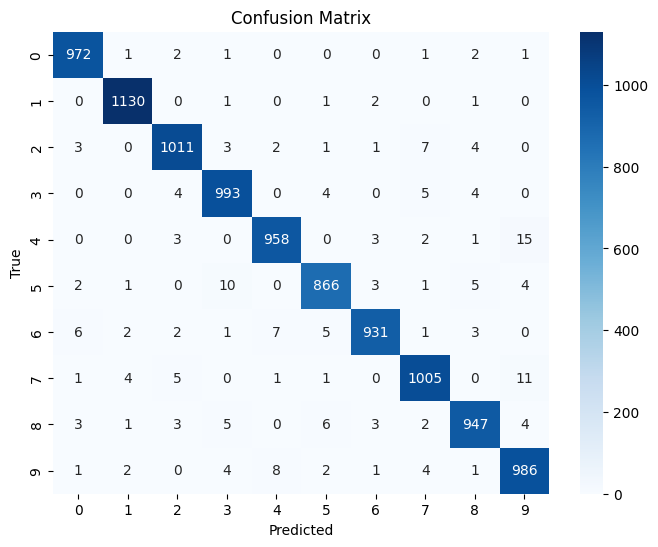

In [ ]:
#baseline model with ReLU activation function
experiment(id = 2, batch_size = 64, hidden_layers = [500,250,100],  learning_rate = 0.01, init_method = "Glorot", activation = "relu", optimization = "sgd", log_interval = 200, epochs = 15)


*   With TanH activation function it reaches upto 92% accuracy.

starting experiment:  3
cpu


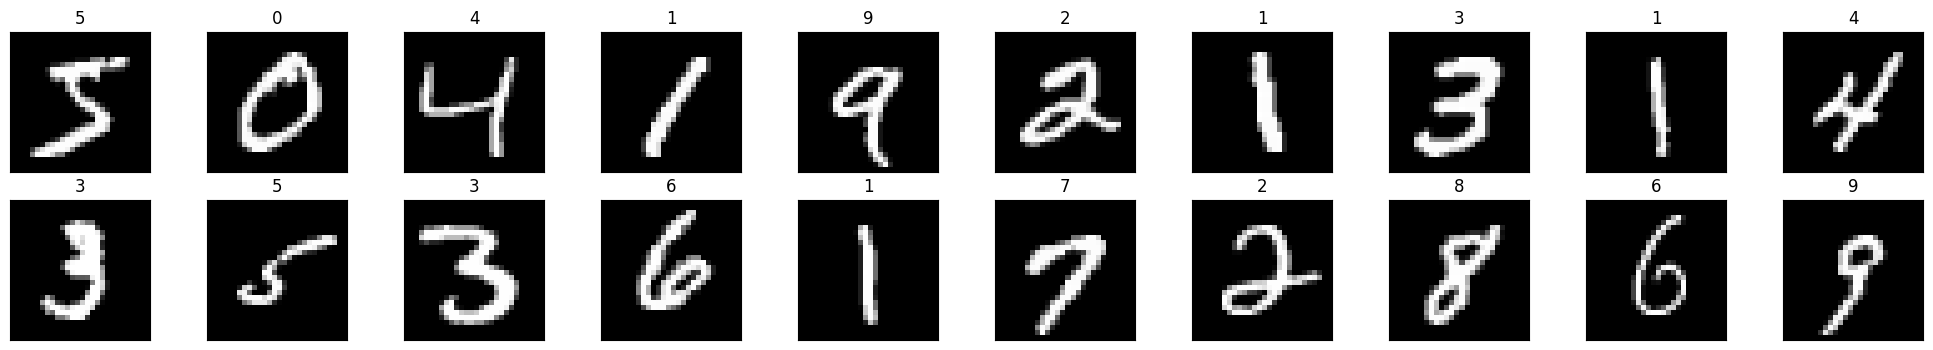

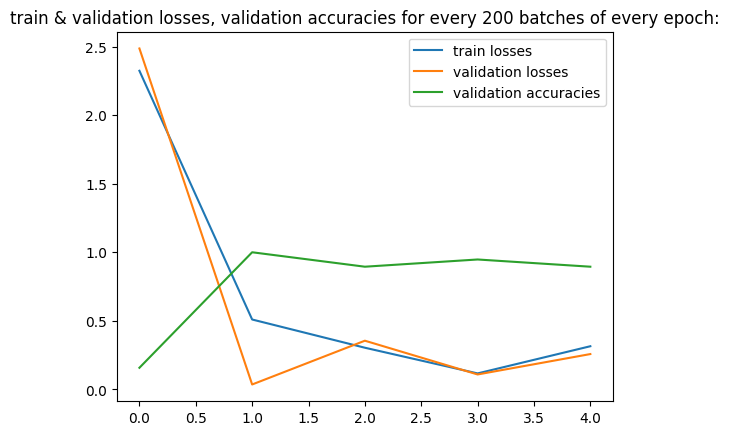

test accuracy:  0.9295
total test loss: 0.2308995457833746
experiment  3 completed
******************************************************************************************************************************************************


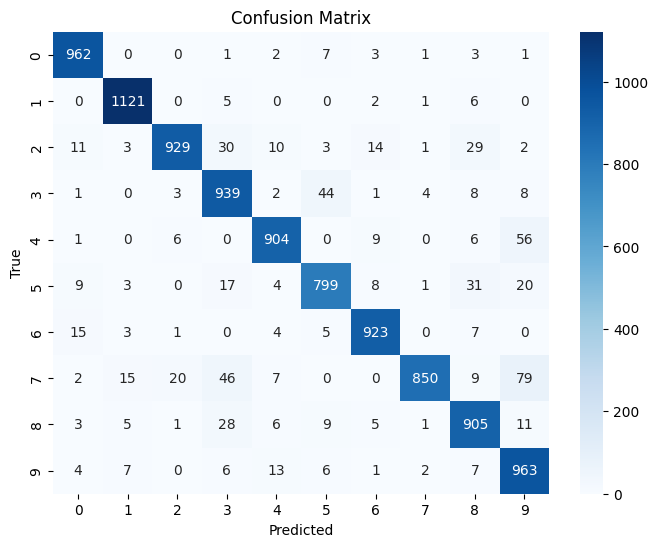

In [ ]:
#baseline model with tanh activation function
experiment(id = 3, batch_size = 64, hidden_layers = [500,250,100],  learning_rate = 0.01, init_method = "Glorot", activation = "tanh", optimization = "sgd", log_interval = 200, epochs = 15)



*   The following configuration achieves 90% accuracy.



starting experiment:  4
cpu


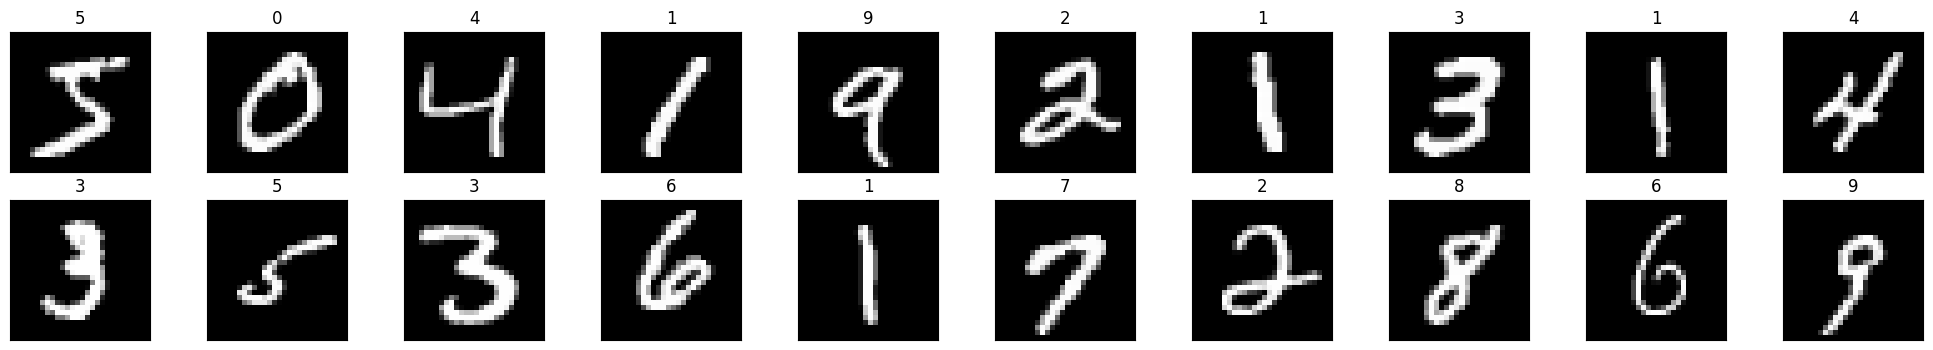

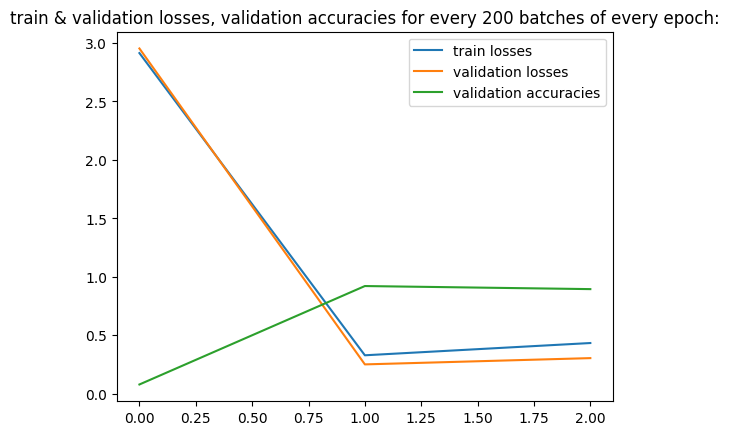

test accuracy:  0.9059
total test loss: 0.2999358152358993
experiment  4 completed
******************************************************************************************************************************************************


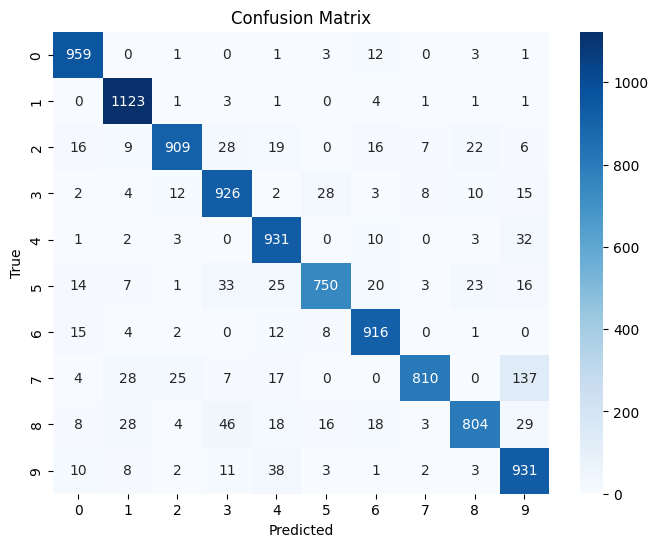

In [ ]:
#experiment with different network layer architecture, initialization method and activation funcntion
experiment(id = 4, batch_size = 128, hidden_layers = [500, 1000, 100], learning_rate = 0.001, init_method = "he", activation = "tanh", optimization = "sgd", log_interval = 200, epochs = 15)



*   The following configuration gives 91% accuracy



starting experiment:  5
cpu


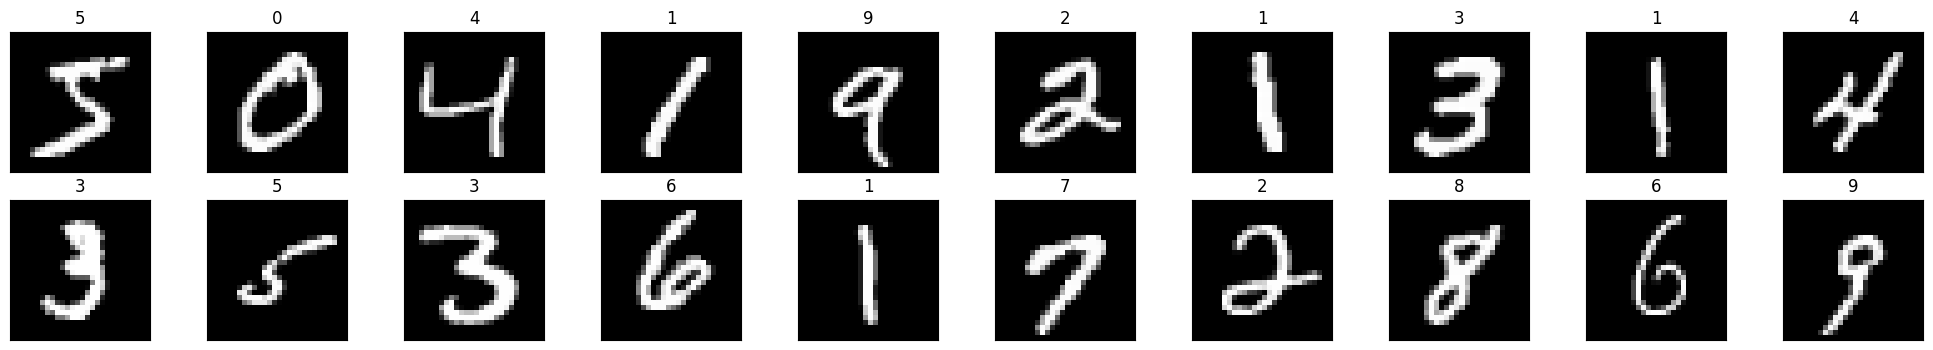

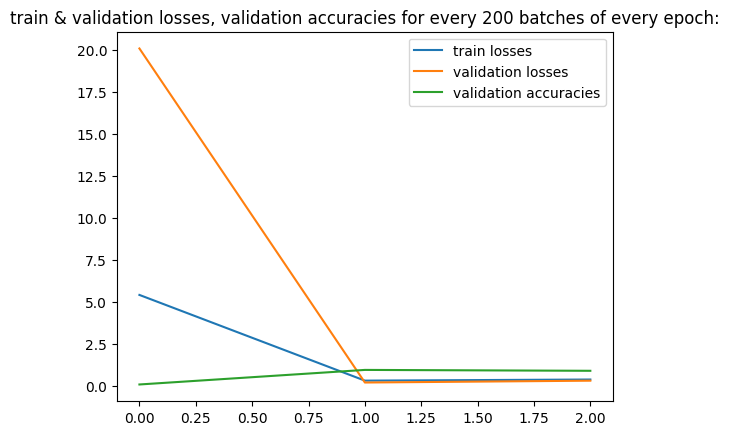

test accuracy:  0.9128
total test loss: 0.28627762968986187
experiment  5 completed
******************************************************************************************************************************************************


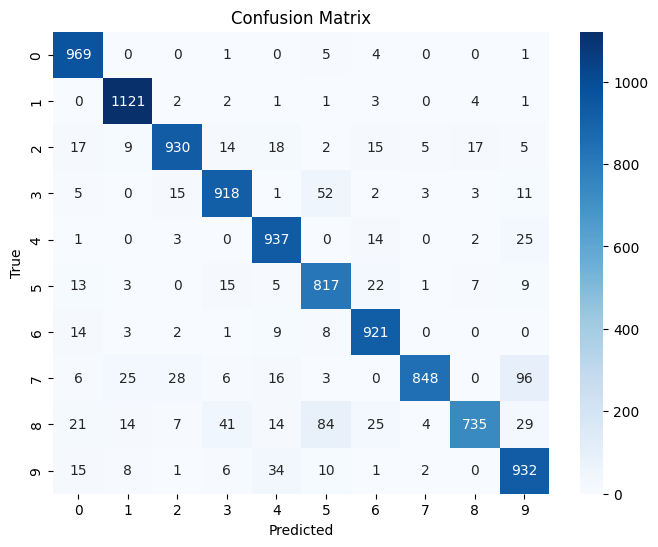

In [ ]:
#experiment with different network layer architecture, initialization method and activation funcntion
experiment(id = 5, batch_size = 128, hidden_layers = [500, 1000, 100], learning_rate = 0.001, init_method = "he", activation = "relu", optimization = "sgd", log_interval = 200, epochs = 1)



*  The following configuration gives 85% accuracy



starting experiment:  5
cpu


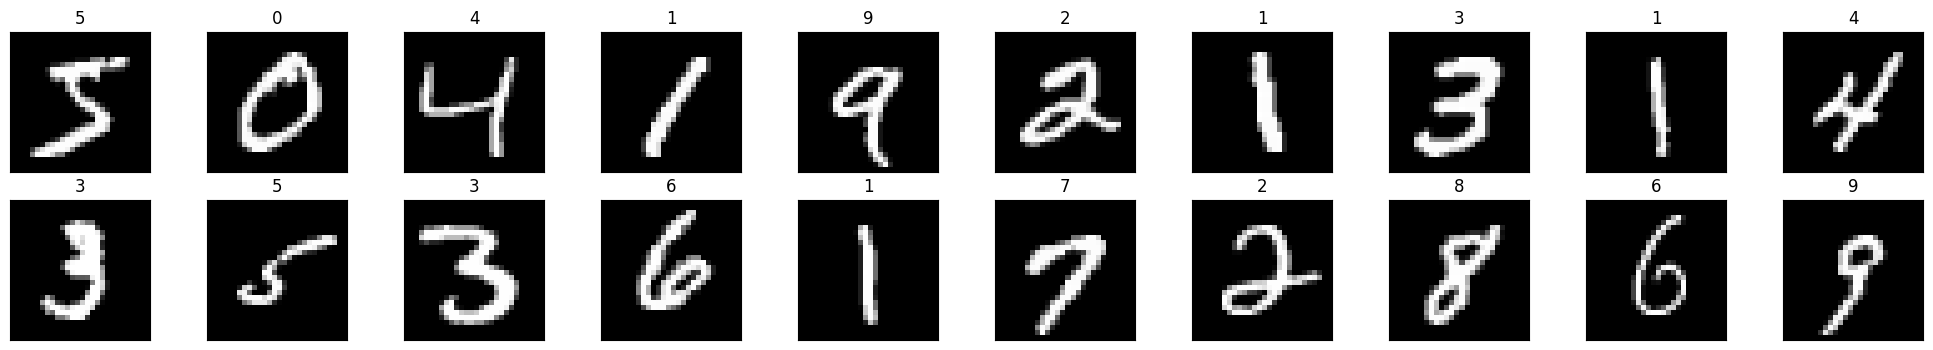

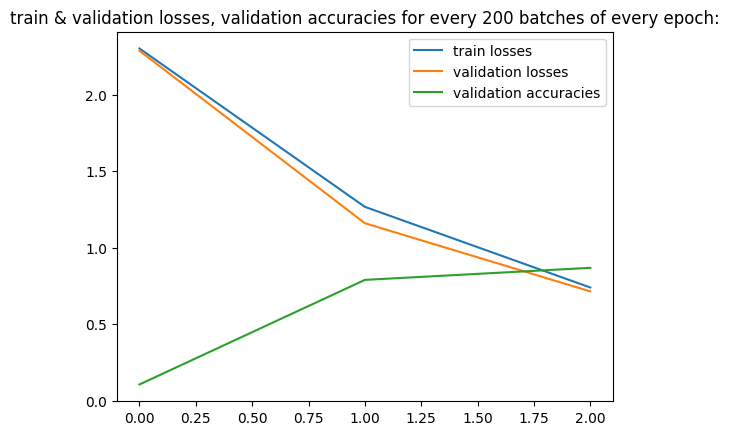

test accuracy:  0.8584
total test loss: 0.6131417360195744
experiment  5 completed
******************************************************************************************************************************************************


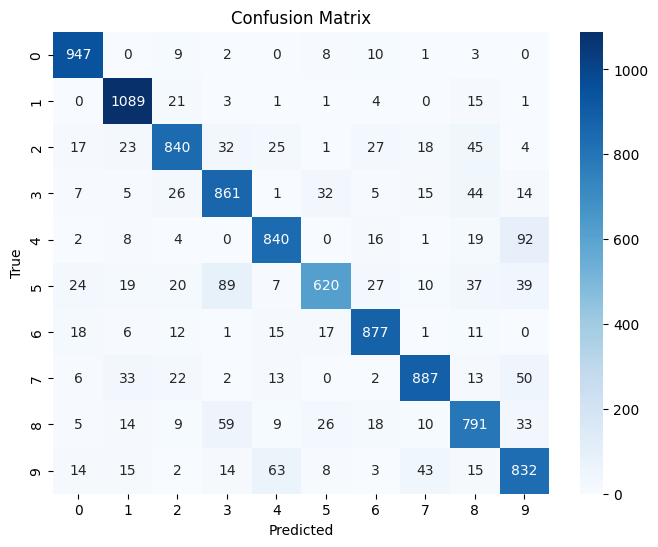

In [ ]:
#experiment with different network layer architecture, initialization method and activation funcntion
experiment(id = 6,batch_size = 128, hidden_layers = [500, 1000, 100], learning_rate = 0.01, init_method = "Glorot", activation = "relu", optimization = "adam", log_interval = 200, epochs = 15)

Clearly it can be observed that ReLU performs better as activation function. The reason could be the Glort initialization, since weights are initialized around zero mean, it balances the positives and negatives well from the activation and explains the features well.
Therefore the same configuration has been used in pytorch as well.